In [35]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import pickle
import sys, os
sys.path.insert(0,'../scripts/')
from data_fetch import get_data
from helper import Helper
from plot import plotly_multi_hist

In [2]:
data = get_data('data/cleaned_data.csv','C:/Users/User/Desktop/Telecom-data-analysis','cleaned_data_v1')

In [3]:
df_telco_user_experience = data[['MSISDN/Number','Avg RTT DL (ms)','Avg RTT UL (ms)','Avg Bearer TP DL (kbps)','Avg Bearer TP UL (kbps)','TCP DL Retrans. Vol (Bytes)','TCP UL Retrans. Vol (Bytes)','Handset Type']]
df_telco_user_experience

MSISDN/Number  Avg RTT DL (ms)  Avg RTT UL (ms)  \
0         33664962239             42.0              5.0   
1         33681854413             65.0              5.0   
2         33760627129            102.0              5.0   
3         33750343200            102.0              5.0   
4         33699795932            102.0              5.0   
...               ...              ...              ...   
146882    33762146363             27.0              2.0   
146883    33761274518             37.0              4.0   
146884    33626114091             46.0              6.0   
146885    33645655643            313.0              9.0   
146886    33668648496            313.0              9.0   

        Avg Bearer TP DL (kbps)  Avg Bearer TP UL (kbps)  \
0                          23.0                     44.0   
1                          16.0                     26.0   
2                           6.0                      9.0   
3                          44.0                     44.0   
4                           6.0                      9.0   
...                         ...                      ...   
146882                     62.0                     54.0   
146883                     23.0                     40.0   
146884                     43.0                     41.0   
146885                     55.0                     54.0   
146886                  63420.0                   1393.0   

        TCP DL Retrans. Vol (Bytes)  TCP UL Retrans. Vol (Bytes)  \
0                           19520.0                       7230.0   
1                           19520.0                       7230.0   
2                           19520.0                       7230.0   
3                           19520.0                       7230.0   
4                           19520.0                       7230.0   
...                             ...                          ...   
146882                   16552848.0                     162614.0   
146883                   16552848.0                     162614.0   
146884                   16552848.0                     162614.0   
146885                   16552848.0                     162614.0   
146886                   16552848.0                     162614.0   

                        Handset Type  
0         Samsung Galaxy A5 Sm-A520F  
1        Samsung Galaxy J5 (Sm-J530)  
2           Samsung Galaxy A8 (2018)  
3                          undefined  
4                   Samsung Sm-G390F  
...                              ...  
146882  Apple iPhone 6S Plus (A1687)  
146883       Apple iPhone 6S (A1688)  
146884       Apple iPhone Xr (A2105)  
146885   Samsung Galaxy J5 (Sm-J530)  
146886                     undefined  

[146887 rows x 8 columns]

In [4]:
df_telco_user_experience['Total Avg RTT (ms)'] = df_telco_user_experience['Avg RTT DL (ms)'] + df_telco_user_experience['Avg RTT UL (ms)']
df_telco_user_experience['Total Avg Bearer TP (kbps)'] = df_telco_user_experience['Avg Bearer TP DL (kbps)'] + df_telco_user_experience['Avg Bearer TP UL (kbps)']
df_telco_user_experience['Total TCP Retrans. Vol (Bytes)'] = df_telco_user_experience['TCP DL Retrans. Vol (Bytes)'] + df_telco_user_experience['TCP UL Retrans. Vol (Bytes)']
df_telco_user_experience.info()

C:\Users\User\AppData\Local\Temp\ipykernel_3784\1558040006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_telco_user_experience['Total Avg RTT (ms)'] = df_telco_user_experience['Avg RTT DL (ms)'] + df_telco_user_experience['Avg RTT UL (ms)']
C:\Users\User\AppData\Local\Temp\ipykernel_3784\1558040006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_telco_user_experience['Total Avg Bearer TP (kbps)'] = df_telco_user_experience['Avg Bearer TP DL (kbps)'] + df_telco_user_experience['Avg Bearer TP 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146887 entries, 0 to 146886
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   MSISDN/Number                   146887 non-null  int64  
 1   Avg RTT DL (ms)                 146887 non-null  float64
 2   Avg RTT UL (ms)                 146887 non-null  float64
 3   Avg Bearer TP DL (kbps)         146887 non-null  float64
 4   Avg Bearer TP UL (kbps)         146887 non-null  float64
 5   TCP DL Retrans. Vol (Bytes)     146887 non-null  float64
 6   TCP UL Retrans. Vol (Bytes)     146887 non-null  float64
 7   Handset Type                    146887 non-null  object 
 8   Total Avg RTT (ms)              146887 non-null  float64
 9   Total Avg Bearer TP (kbps)      146887 non-null  float64
 10  Total TCP Retrans. Vol (Bytes)  146887 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 12.3+ MB


In [5]:
df_telco_user_experience_agg = df_telco_user_experience.groupby('MSISDN/Number').agg({ 'Total Avg RTT (ms)': 'sum','Total Avg Bearer TP (kbps)': 'sum','Total TCP Retrans. Vol (Bytes)': 'sum','Handset Type': [lambda x: x.mode()[0]]})
df_telco_user_experience_agg.head()

Total Avg RTT (ms) Total Avg Bearer TP (kbps)  \
                             sum                        sum   
MSISDN/Number                                                 
33601001722                 46.0                       76.0   
33601001754                 31.0                       99.0   
33601002511                 59.0                       97.0   
33601007832                 84.0                      248.0   
33601008617                119.0                    56844.0   

              Total TCP Retrans. Vol (Bytes)                    Handset Type  
                                         sum                        <lambda>  
MSISDN/Number                                                                 
33601001722                        2895381.0  Huawei P20 Lite Huawei Nova 3E  
33601001754                        9272453.0          Apple iPhone 7 (A1778)  
33601002511                        4150403.0                       undefined  
33601007832                           2396.0         Apple iPhone 5S (A1457)  
33601008617                        9738882.0         Apple iPhone Se (A1723)

In [10]:
df_telco_user_experience_agg_new = pd.DataFrame(columns=["Total Avg RTT (ms)","Total Avg Bearer TP (kbps)","Total TCP Retrans. Vol (Bytes)","Handset Type"])
df_telco_user_experience_agg_new["Total Avg RTT (ms)"] = df_telco_user_experience_agg["Total Avg RTT (ms)"]['sum']
df_telco_user_experience_agg_new["Total Avg Bearer TP (kbps)"] = df_telco_user_experience_agg["Total Avg Bearer TP (kbps)"]['sum']
df_telco_user_experience_agg_new["Total TCP Retrans. Vol (Bytes)"] = df_telco_user_experience_agg["Total TCP Retrans. Vol (Bytes)"]['sum']
df_telco_user_experience_agg_new["Handset Type"] = df_telco_user_experience_agg["Handset Type"]['<lambda>']
df_telco_user_experience_agg_new.head()

Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  \
MSISDN/Number                                                   
33601001722                  46.0                        76.0   
33601001754                  31.0                        99.0   
33601002511                  59.0                        97.0   
33601007832                  84.0                       248.0   
33601008617                 119.0                     56844.0   

               Total TCP Retrans. Vol (Bytes)                    Handset Type  
MSISDN/Number                                                                  
33601001722                         2895381.0  Huawei P20 Lite Huawei Nova 3E  
33601001754                         9272453.0          Apple iPhone 7 (A1778)  
33601002511                         4150403.0                       undefined  
33601007832                            2396.0         Apple iPhone 5S (A1457)  
33601008617                         9738882.0         Apple iPhone Se (A1723)

In [ ]:
telco_tcp = df_telco_user_experience_agg_new.sort_values('Total TCP Retrans. Vol (Bytes)', ascending=False)
top_10 = telco_tcp.head(10)['Total TCP Retrans. Vol (Bytes)']
bottom_10 = telco_tcp.tail(10)['Total TCP Retrans. Vol (Bytes)']
most_10 = df_telco_user_experience_agg_new['Total TCP Retrans. Vol (Bytes)'].value_counts().head(10)

In [11]:
telco_tcp = df_telco_user_experience_agg_new.sort_values('Total TCP Retrans. Vol (Bytes)', ascending=False)
top_10 = telco_tcp.head(10)['Total TCP Retrans. Vol (Bytes)']
bottom_10 = telco_tcp.tail(10)['Total TCP Retrans. Vol (Bytes)']
most_10 = df_telco_user_experience_agg_new['Total TCP Retrans. Vol (Bytes)'].value_counts().head(10)

In [13]:
import plotly.io as pio
pio.renderers.default = "notebook"
plotly_multi_hist([top_10, bottom_10, most_10], 1, 3,"TCP values", ['Top 10', 'Bottom 10', 'Most 10'])

In [14]:
telco_rtt = df_telco_user_experience_agg_new.sort_values('Total Avg RTT (ms)', ascending=False)
top_10 = telco_rtt.head(10)['Total Avg RTT (ms)']
bottom_10 = telco_rtt.tail(10)['Total Avg RTT (ms)']
most_10 = df_telco_user_experience_agg_new['Total Avg RTT (ms)'].value_counts().head(10)

In [15]:
plotly_multi_hist([top_10, bottom_10, most_10], 1, 3,"RTT values", ['Top 10', 'Bottom 10', 'Most 10'])

In [16]:
telco_tp = df_telco_user_experience_agg_new.sort_values('Total Avg Bearer TP (kbps)', ascending=False)
top_10 = telco_tp.head(10)['Total Avg Bearer TP (kbps)']
bottom_10 = telco_tp.tail(10)['Total Avg Bearer TP (kbps)']
most_10 = df_telco_user_experience_agg_new['Total Avg Bearer TP (kbps)'].value_counts().head(10)

In [17]:
plotly_multi_hist([top_10, bottom_10, most_10], 1, 3,"TP values", ['Top 10', 'Bottom 10', 'Most 10'])

In [18]:
df_telco_handset_type = df_telco_user_experience_agg_new.groupby('Handset Type').mean()
df_telco_handset_type.head()

Total Avg RTT (ms)  \
Handset Type                                            
A-Link Telecom I. Cubot A5                       42.0   
A-Link Telecom I. Cubot Note Plus              1589.0   
A-Link Telecom I. Cubot Note S                  890.0   
A-Link Telecom I. Cubot Nova                     44.0   
A-Link Telecom I. Cubot Power                    43.0   

                                   Total Avg Bearer TP (kbps)  \
Handset Type                                                    
A-Link Telecom I. Cubot A5                            23510.0   
A-Link Telecom I. Cubot Note Plus                      6699.0   
A-Link Telecom I. Cubot Note S                         8937.0   
A-Link Telecom I. Cubot Nova                          56217.0   
A-Link Telecom I. Cubot Power                         69468.0   

                                   Total TCP Retrans. Vol (Bytes)  
Handset Type                                                       
A-Link Telecom I. Cubot A5                              9541170.0  
A-Link Telecom I. Cubot Note Plus                        616213.0  
A-Link Telecom I. Cubot Note S                         41411731.0  
A-Link Telecom I. Cubot Nova                             137170.0  
A-Link Telecom I. Cubot Power                              8041.0

In [19]:
df_telco_handset_tp = df_telco_handset_type.sort_values('Total Avg Bearer TP (kbps)', ascending=False)
df_telco_handset_tp.head()

Total Avg RTT (ms)  \
Handset Type                                             
Spa Condor Elect. Allure M2                       90.0   
Huawei Par-Lx9                                   259.0   
Huawei B715S-23C                                 153.6   
Asustek Wireless-Ac1200 Lte Router               207.0   
New-Bund Technol. Thor                            81.5   

                                    Total Avg Bearer TP (kbps)  \
Handset Type                                                     
Spa Condor Elect. Allure M2                           168623.0   
Huawei Par-Lx9                                        144115.0   
Huawei B715S-23C                                      141692.5   
Asustek Wireless-Ac1200 Lte Router                    125525.0   
New-Bund Technol. Thor                                113444.5   

                                    Total TCP Retrans. Vol (Bytes)  
Handset Type                                                        
Spa Condor Elect. Allure M2                                89016.0  
Huawei Par-Lx9                                           2896635.0  
Huawei B715S-23C                                        44737973.1  
Asustek Wireless-Ac1200 Lte Router                       8780527.0  
New-Bund Technol. Thor                                   3949428.0

In [20]:
df_telco_handset_tcp = df_telco_handset_type.sort_values('Total TCP Retrans. Vol (Bytes)', ascending=False)
df_telco_handset_tcp.head()

Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  \
Handset Type                                                               
Simcom Wireless. Sim800H           52.000000                         8.0   
Lg Lg-H635                         80.333333                     25339.0   
Sfr Star Trail 5 By Sfr           587.000000                      9718.0   
Huawei Bln-Al10                   292.000000                      5761.0   
Mikrotikls Sia R11E-Lte            70.000000                       544.0   

                          Total TCP Retrans. Vol (Bytes)  
Handset Type                                              
Simcom Wireless. Sim800H                    4.344116e+09  
Lg Lg-H635                                  9.048730e+08  
Sfr Star Trail 5 By Sfr                     4.324750e+08  
Huawei Bln-Al10                             3.291746e+08  
Mikrotikls Sia R11E-Lte                     3.216885e+08

<AxesSubplot:>

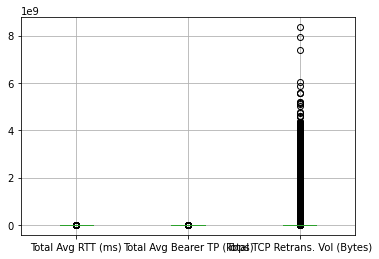

In [21]:
df_telco_user_experience_agg_new.boxplot()

In [22]:
df_telco_user_experience_agg_new = df_telco_user_experience_agg_new[["Total Avg RTT (ms)","Total Avg Bearer TP (kbps)","Total TCP Retrans. Vol (Bytes)"]]
helper = Helper(df_telco_user_experience_agg_new)
helper.getOverview(["Total Avg RTT (ms)","Total Avg Bearer TP (kbps)","Total TCP Retrans. Vol (Bytes)"])

Name of columns        Total TCP Retrans. Vol (Bytes) Total Avg RTT (ms)  \
Min                                              51.0                0.0   
Q1                                           83894.25               39.0   
Median                                       763893.0               66.0   
Q3                                          4916588.5              127.0   
Max                                      8354209105.0            96924.0   
IQR                                        4832694.25               88.0   
Lower fence                              -7165147.125              -93.0   
Upper fence                              12165629.875              259.0   
Skew                                        15.005466          52.395845   
Number_of_outliers                              15405              11757   
Percentage_of_outliers                         10.27%              7.84%   

Name of columns        Total Avg Bearer TP (kbps)  
Min                                           0.0  
Q1                                           97.0  
Median                                      302.0  
Q3                                       26790.25  
Max                                      902222.0  
IQR                                      26693.25  
Lower fence                            -39942.875  
Upper fence                             66830.125  
Skew                                      3.95796  
Number_of_outliers                          10456  
Percentage_of_outliers                      6.97%

In [23]:
helper.replace_outliers_with_fences(["Total Avg RTT (ms)","Total Avg Bearer TP (kbps)","Total TCP Retrans. Vol (Bytes)"])
helper.getOverview(["Total Avg RTT (ms)","Total Avg Bearer TP (kbps)","Total TCP Retrans. Vol (Bytes)"])

Name of columns        Total Avg RTT (ms) Total Avg Bearer TP (kbps)  \
Min                                   0.0                        0.0   
Q1                                   39.0                       97.0   
Median                               66.0                      302.0   
Q3                                  127.0                   26790.25   
Max                                 259.0                  66830.125   
IQR                                  88.0                   26693.25   
Lower fence                         -93.0                 -39942.875   
Upper fence                         259.0                  66830.125   
Skew                              1.15141                   1.266765   
Number_of_outliers                      0                          0   
Percentage_of_outliers               0.0%                       0.0%   

Name of columns        Total TCP Retrans. Vol (Bytes)  
Min                                              51.0  
Q1                                           83894.25  
Median                                       763893.0  
Q3                                          4916588.5  
Max                                      12165629.875  
IQR                                        4832694.25  
Lower fence                              -7165147.125  
Upper fence                              12165629.875  
Skew                                         1.212943  
Number_of_outliers                                  0  
Percentage_of_outliers                           0.0%

<AxesSubplot:>

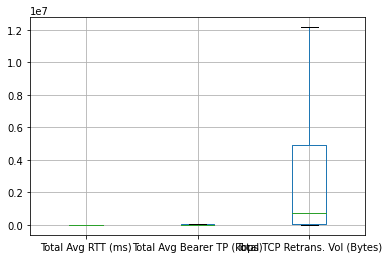

In [24]:
df_telco_user_experience_agg_new.boxplot()

In [25]:
scaler_instance = StandardScaler()
scaled_data = scaler_instance.fit_transform(df_telco_user_experience_agg_new)
scaled_data

array([[-0.66447913, -0.66553306, -0.07718727],
       [-0.86244675, -0.66454954,  1.36477629],
       [-0.4929072 , -0.66463506,  0.20659437],
       ...,
       [-0.58529209, -0.22555909, -0.68257811],
       [-0.74366618, -0.66382259, -0.67580862],
       [-0.77006186, -0.66737181, -0.70461297]])

In [26]:
normalized_data = normalize(scaled_data)
normalized_data

array([[-0.7041785 , -0.70529539, -0.08179883],
       [-0.49399312, -0.38064136,  0.78171795],
       [-0.5779429 , -0.77929702,  0.24223576],
       ...,
       [-0.63137291, -0.24331765, -0.73631839],
       [-0.61749234, -0.55119538, -0.56114781],
       [-0.62157173, -0.53868328, -0.56874327]])

In [27]:
kmeans = KMeans(n_clusters=3, random_state=1).fit(normalized_data)
kmeans.labels_

array([0, 2, 0, ..., 0, 0, 0])

In [28]:
df_telco_user_experience_agg_new.insert(0, 'cluster', kmeans.labels_)
df_telco_user_experience_agg_new

cluster  Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  \
MSISDN/Number                                                              
33601001722            0                46.0                      76.000   
33601001754            2                31.0                      99.000   
33601002511            0                59.0                      97.000   
33601007832            0                84.0                     248.000   
33601008617            1               119.0                   56844.000   
...                  ...                 ...                         ...   
33789967113            0                53.0                      67.000   
33789980299            1               116.0                   66830.125   
33789996170            0                52.0                   10365.000   
33789997247            0                40.0                     116.000   
337000037000919        0                38.0                      33.000   

                 Total TCP Retrans. Vol (Bytes)  
MSISDN/Number                                    
33601001722                           2895381.0  
33601001754                           9272453.0  
33601002511                           4150403.0  
33601007832                              2396.0  
33601008617                           9738882.0  
...                                         ...  
33789967113                             56578.0  
33789980299                          10617270.0  
33789996170                            218045.0  
33789997247                            247983.0  
337000037000919                        120596.0  

[105716 rows x 4 columns]

In [29]:
df_telco_user_experience_agg_new['cluster'].value_counts()

0    51606
1    36554
2    17556
Name: cluster, dtype: int64

In [30]:
fig = px.scatter(df_telco_user_experience_agg_new, x='Total TCP Retrans. Vol (Bytes)', y='Total Avg Bearer TP (kbps)',color='cluster', size='Total Avg RTT (ms)')
fig.show()

In [31]:
cluster0 = df_telco_user_experience_agg_new[df_telco_user_experience_agg_new["cluster"]==0]
cluster0[["Total Avg RTT (ms)","Total Avg Bearer TP (kbps)","Total TCP Retrans. Vol (Bytes)"]].describe()

Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  \
count        51606.000000                51606.000000   
mean            52.126032                 2421.044820   
std             26.493964                 5884.397741   
min              0.000000                    0.000000   
25%             32.000000                   84.000000   
50%             45.000000                  109.000000   
75%             64.000000                  401.000000   
max            156.000000                35574.000000   

       Total TCP Retrans. Vol (Bytes)  
count                    5.160600e+04  
mean                     6.136186e+05  
std                      9.533746e+05  
min                      5.100000e+01  
25%                      2.660900e+04  
50%                      1.506270e+05  
75%                      7.562432e+05  
max                      4.766930e+06

In [32]:
cluster1 = df_telco_user_experience_agg_new[df_telco_user_experience_agg_new["cluster"]==1]
cluster1[["Total Avg RTT (ms)","Total Avg Bearer TP (kbps)","Total TCP Retrans. Vol (Bytes)"]].describe()

Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  \
count        36554.000000                36554.000000   
mean           163.449445                38897.369221   
std             79.875431                24987.713230   
min             19.000000                    0.000000   
25%             89.000000                15503.250000   
50%            159.000000                41575.500000   
75%            259.000000                66830.125000   
max            259.000000                66830.125000   

       Total TCP Retrans. Vol (Bytes)  
count                    3.655400e+04  
mean                     3.604981e+06  
std                      4.316622e+06  
min                      1.690000e+02  
25%                      2.741708e+05  
50%                      1.545806e+06  
75%                      5.490064e+06  
max                      1.216563e+07

In [33]:
cluster2 = df_telco_user_experience_agg_new[df_telco_user_experience_agg_new["cluster"]==2]
cluster2[["Total Avg RTT (ms)","Total Avg Bearer TP (kbps)","Total TCP Retrans. Vol (Bytes)"]].describe()

Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  \
count        17556.000000                17556.000000   
mean            86.621782                 6071.023553   
std             63.291377                12643.955250   
min              8.000000                    0.000000   
25%             39.000000                   93.000000   
50%             67.000000                  143.000000   
75%            113.000000                 2641.250000   
max            259.000000                66830.125000   

       Total TCP Retrans. Vol (Bytes)  
count                    1.755600e+04  
mean                     1.018070e+07  
std                      2.753133e+06  
min                      3.137119e+06  
25%                      7.820581e+06  
50%                      1.216563e+07  
75%                      1.216563e+07  
max                      1.216563e+07

In [34]:
df_telco_user_experience_agg_new.to_csv('../data/user_experience_data.csv')

In [37]:
with open("../models/user_experience_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)